# Tutorial 2: Step-by-step scATAC-seq analysis

Here we will use scATAC-seq dataset `Forebrain' as an example to illustrate how scAGDE performs scATAC-seq analysis in an step-by-step style.

## 1. Read and preprocess data

We first read '.h5ad' data file using [Scanpy](https://github.com/scverse/scanpy) package

In [2]:
import scanpy as sc
adata = sc.read_h5ad("data/Forebrain.h5ad")

We can use Scanpy to further filter data. In our case, we pass this step because the loaded dataset has been preprocessed. Some codes for filtering are copied below for easy reference:

In [3]:
sc.pp.filter_cells(adata, min_genes=100)
min_cells = int(adata.shape[0] * 0.01)
sc.pp.filter_genes(adata, min_cells=min_cells)

In [4]:
adata

AnnData object with n_obs × n_vars = 2088 × 11285
    obs: 'celltype', 'n_genes'
    var: 'n_cells'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## 2. Setup and train scAGDE model

Now we can initialize the trainer with the AnnData object, which will ensure settings for model are in place for training. 

We can specify the `outdir` to the dir path where we want to save the output file (mainly the model weights file).

`n_centroids` represents the cluster number of dataset. If this information is unknown, we can set `n_centroids=None` and in this case, scAGDE will apply the estimation strategy to estimate the optimal cluster number for the initialization of its cluster layer. Here, we set `n_centroids=None` to allow the estimation strategy.
 
We can train scAGDE on specified device by setting `gpu`. For example, train scAGDE on CPUs by `gpu=None` and trian it on GPU #0 by `gpu="0"`

<div class='alert alert-block alert-info'>
If you are merely interested in learning cell embeddings without consiering any optimization about cell clustering, you can specify `cluster_opt=False` here. In this case, scAGDE will be run withour any clustering-related module and optimization.
 </div>

In [5]:
import scAGDE
trainer = scAGDE.Trainer(adata,outdir="output",n_centroids=None,gpu="3")

device used: cuda:3



### 2.1 Train the chromatin accessibility-based autoencoder

Now we can train scAGDE model in step-by-step style. First, we train an chromatin accessibility-based autoencoder to measure the importance of the peaks and select the key peaks. In the meanwhile, the initial cell representations for cell graph construction are stored in `adata.obs[embed_init_key]`, which is `"latent_init"` in default.

In [6]:
trainer.CountModel(embed_init_key="latent_init")

Cell number: 2088
Peak number: 11285
n_centroids: None


## Training CountModel ##


CountModel: 100%|██████████| 5000/5000 [00:31<00:00, 159.14it/s, loss=1687.1017]


Resolution: 0.1, Clusters: 4, Silhouette Score: 0.2519724369049072
Resolution: 0.2, Clusters: 6, Silhouette Score: 0.2892927825450897
Resolution: 0.30000000000000004, Clusters: 6, Silhouette Score: 0.288756400346756
Resolution: 0.4, Clusters: 7, Silhouette Score: 0.23812147974967957
Resolution: 0.5, Clusters: 8, Silhouette Score: 0.23155203461647034
Resolution: 0.6, Clusters: 8, Silhouette Score: 0.22821781039237976
Resolution: 0.7000000000000001, Clusters: 8, Silhouette Score: 0.2266818881034851
Resolution: 0.8, Clusters: 8, Silhouette Score: 0.22870215773582458
Resolution: 0.9, Clusters: 9, Silhouette Score: 0.21382907032966614
Resolution: 1.0, Clusters: 10, Silhouette Score: 0.2054450511932373
Estimated Optimal Number of Clusters: 6 at Resolution: 0.2


At this time, scAGDE yields an estimate of 6, which will be used for the dimension initialization of cluster layer's centroids. We can get the estimate value as below:

In [7]:
print("The estimate of cluster number is: %d" % trainer.estimates)

The estimate of cluster number is: 6


### 2.2 Peak selection

Next, we can filter peaks based on the peak importance scores which are calculated in the last step. The importance scores are stored in `trainer.peakImportance` and can be plotted by function of `trainer.plotPeakImportance()` 

[0.07481935 0.16716415 0.20202534 ... 0.2636149  0.19474538 0.18491967]


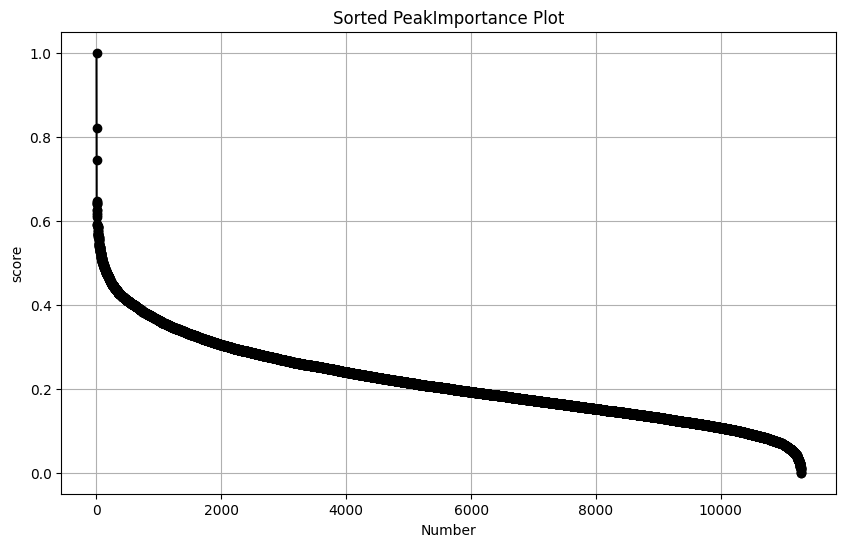

In [8]:
print(trainer.peakImportance)
trainer.plotPeakImportance()

Accordding to plot, there is a elbow inflection point (after 6k) to identify the top importance peaks using the elbow method. In practice, a conservative choice of this parameter will not significantly impact the results. Here, we can select 8,000 or more peaks for further model training. 

Next, we can excute the code below to select `topn` important peaks. By setting `replace=False`, the AnnData object will not be replaced with subset dataset but the features will be marked as 1 if selected, which is stored in `adata.var[selected_key]`.

In [34]:
trainer.peakSelect(topn=8000, replace=False, selected_key="is_selected")

### 2.3 Train GCN-based embedded model

Lastly, we train the GCN-based embedded model by `trainer.GraphModel()`. scAGDE finally yiels robust and discriminative cell embeddings which are stored in `adata.obsm[embed_key]`, which is `"latent"` in default. Also, scAGDE enables imputation task if `impute_key` is not None and the imputed data will be stored in `adata.obsm[impute_key]`, which is `"impute"` in default. 

scAGDE performs clustering on final embeddings if `cluster_key` is not None, and the cluster assignments will be in `adata.obs[cluster_key]`, which is `"cluster"` in default. Because we have enabled the estimation strategy, the cluster number will be set to the value of estimates.

In [35]:
adata = trainer.GraphModel(impute_key="impute",cluster_key="cluster",embed_key="latent")
print(adata)


## Constructing Cell Graph ##
Cell number: 2088
Peak number: 8000
n_centroids: 6


## Training GraphModel ##


GraphModel: 100%|██████████| 4000/4000 [01:06<00:00, 59.93it/s, loss=3476.6477]


AnnData object with n_obs × n_vars = 2088 × 11285
    obs: 'celltype', 'n_genes', 'cluster'
    var: 'n_cells', 'is_selected'
    uns: 'neighbors', 'pca', 'tsne', 'umap', 'celltype_colors', 'cluster_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'latent_init', 'impute', 'latent'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


To get more reliable cluster results, we can re-estimate the cluster number on final cell embeddings and re-perform cluster.

In [42]:
# re-estimate
best_k, best_resolution = scAGDE.utils.estimate_optimal_k_louvain(adata.obsm["latent"])
cluster = scAGDE.mclust.mclust_R(adata.obsm["latent"],best_k)
adata.obs["cluster"] = cluster.astype(int).astype(str)

Resolution: 0.1, Clusters: 5, Silhouette Score: 0.2183424472808838
Resolution: 0.2, Clusters: 6, Silhouette Score: 0.2397676348686218
Resolution: 0.3, Clusters: 8, Silhouette Score: 0.3397676348686218
Resolution: 0.4, Clusters: 8, Silhouette Score: 0.33547508478164673
Resolution: 0.5, Clusters: 8, Silhouette Score: 0.3355008637905121
Resolution: 0.6, Clusters: 8, Silhouette Score: 0.33356576919555664
Resolution: 0.7000000000000001, Clusters: 9, Silhouette Score: 0.2483772188425064
Resolution: 0.8, Clusters: 10, Silhouette Score: 0.24761515855789185
Resolution: 0.9, Clusters: 13, Silhouette Score: 0.1840001940727234
Resolution: 1.0, Clusters: 13, Silhouette Score: 0.18204689025878906
Estimated Optimal Number of Clusters: 8 at Resolution: 0.3


## 3. Visualizing and evaluation

We can now use Scanpy to visualize our latent space.

/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/haogaoyang/anaconda3/envs/torch/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


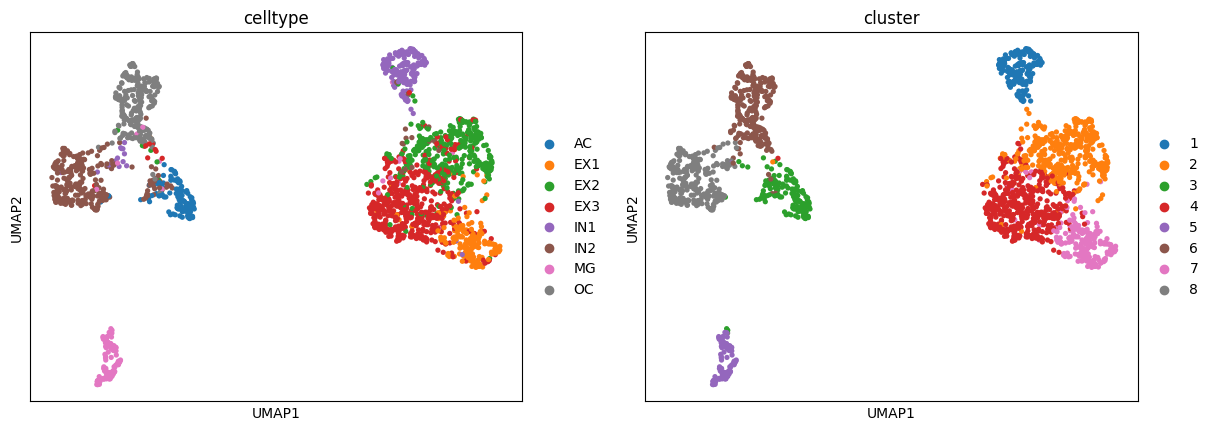

In [43]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata, min_dist=0.2)
sc.pl.umap(adata,color=["celltype","cluster"])

We can evaluate the clustering performance with multiple metrics as below:

In [44]:
y = adata.obs["celltype"].astype("category").cat.codes.values
res = scAGDE.utils.cluster_report(y, adata.obs["cluster"].astype(int))


## Clustering Evaluation Report ##
# Confusion matrix: #
[[115   0   0   0   0   3   0   2]
 [  0 170   6  13   0   0   0   1]
 [  1   8 315  34   5   0   0   3]
 [  1  28  77 403   1   2   0   7]
 [  2   3   3   2 171   7   1   6]
 [ 37   0  10   3   2 267   0   1]
 [  4   1   4   3   1   2 108   3]
 [  0   0   0   0   0   1   0 251]]
# Metric values: #
Adjusted Rand Index: 0.6907
Normalized Mutual Info: 0.7406
F1 score: 0.8621
